# psmc-rs Core Experiments (Rust vs C)

This notebook is for **paper-ready core experiments** in this repository:

1. Simulate 4 standard models (`constant`, `bottleneck`, `expansion`, `zigzag`) with stdpopsim helper script.
2. Run `psmc-rs` and C `psmc` on the same inputs.
3. Evaluate accuracy with `RMSE(log10 Ne)` vs known truth.
4. Benchmark runtime + peak RSS memory.
5. Test `batch-size` robustness.
6. Evaluate bootstrap CI behavior and coverage.

Real-data experiment is intentionally not included here (you said you will provide it).


In [ ]:
!pip install stdpopsim msprime tskit
from __future__ import annotations

import json
import math
import os
import platform
import shlex
import subprocess
import sys
import time
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import psutil
    HAS_PSUTIL = True
except Exception:
    HAS_PSUTIL = False

ROOT = Path.cwd().resolve()
assert (ROOT / 'Cargo.toml').exists(), f'Please run this notebook in psmc-rs root. current={ROOT}'

EXP_DIR = ROOT / 'experiments' / 'core'
INPUT_DIR = EXP_DIR / 'inputs'
OUT_DIR = EXP_DIR / 'outputs'
PERF_DIR = EXP_DIR / 'perf'
for d in (EXP_DIR, INPUT_DIR, OUT_DIR, PERF_DIR):
    d.mkdir(parents=True, exist_ok=True)

PSMC_RS_BIN = Path(os.environ.get('PSMC_RS_BIN', str(ROOT / 'target' / 'release' / 'psmc')))
C_PSMC_BIN = Path(os.environ.get('C_PSMC_BIN', str(ROOT.parent / 'psmc-master' / 'psmc')))
SIM_SCRIPT = Path(os.environ.get('SIM_SCRIPT', str(ROOT / 'scripts' / 'simulate_msprime_to_psmcfa.py')))

# Base settings
MU = 2.5e-8
GEN_YEARS = 25
BIN_SIZE = 100
N_ITER = 20
T_MAX = 15
N_STEPS = 64
PATTERN = '4+25*2+4+6'
RHO_T_RATIO = 5  # C command uses -r5
BATCH_SIZE_DEFAULT = 300_000

# Paper defaults. You can override by env vars before launching notebook.
SIM_LENGTH = int(os.environ.get('SIM_LENGTH_BP', '500000000'))
SIM_WINDOW = 100
SIM_MUTATION = float(os.environ.get('SIM_MUTATION', str(MU)))
_sim_recomb = os.environ.get('SIM_RECOMB', '').strip()
SIM_RECOMB = float(_sim_recomb) if _sim_recomb else None
PERF_REPEATS = int(os.environ.get('PERF_REPEATS', '3'))
BOOTSTRAP_REPS = int(os.environ.get('BOOTSTRAP_REPS', '50'))
BOOTSTRAP_ITERS = int(os.environ.get('BOOTSTRAP_ITERS', '5'))
ALPHA_CACHE_MB = int(os.environ.get('PSMC_ALPHA_CACHE_MB', '2048'))
THREADS_SWEEP = sorted({int(x.strip()) for x in os.environ.get('THREADS_SWEEP', '1,2,4,8').split(',') if x.strip()})
THREADS_SWEEP = [t for t in THREADS_SWEEP if t >= 1]
PERF_THREADS_REPEATS = int(os.environ.get('PERF_THREADS_REPEATS', '2'))
RUST_BASE_THREADS = int(os.environ.get('RUST_BASE_THREADS', '1'))

print(f'ROOT={ROOT}')
print(f'SIM_LENGTH={SIM_LENGTH:,} bp, WINDOW={SIM_WINDOW} bp, expected symbols={SIM_LENGTH // SIM_WINDOW:,}')
print(f'SIM_MUTATION={SIM_MUTATION:.3e}, SIM_RECOMB={SIM_RECOMB if SIM_RECOMB is not None else "species-default"}')
print(f'PERF_REPEATS={PERF_REPEATS}, BOOTSTRAP_REPS={BOOTSTRAP_REPS}, BOOTSTRAP_ITERS={BOOTSTRAP_ITERS}')
print(f'PSMC_ALPHA_CACHE_MB={ALPHA_CACHE_MB}')
print(f'RUST_BASE_THREADS={RUST_BASE_THREADS}')
print(f'THREADS_SWEEP={THREADS_SWEEP}, PERF_THREADS_REPEATS={PERF_THREADS_REPEATS}')
print(f'psutil_available={HAS_PSUTIL}')

MODELS: Dict[str, Dict] = {
    'constant': {
        'title': 'Constant',
        'sim_model': 'constant',
        'sim_ne': 10_000.0,
        'sim_seed': 42,
        'true_kind': 'constant',
        'true_params': {'ne': 10_000.0},
    },
    'bottleneck': {
        'title': 'Bottleneck',
        'sim_model': 'bottleneck',
        'sim_ne': 20_000.0,
        'sim_seed': 43,
        'true_kind': 'ms_piecewise',
        'true_params': {
            'ne0': 20_000.0,
            'events': [
                (0.01, 0.05),
                (0.015, 0.5),
                (0.05, 0.25),
                (0.5, 0.5),
            ],
        },
    },
    'expansion': {
        'title': 'Expansion',
        'sim_model': 'expansion',
        'sim_ne': 10_000.0,
        'sim_seed': 44,
        'true_kind': 'ms_piecewise',
        'true_params': {
            'ne0': 10_000.0,
            'events': [
                (0.01, 0.1),
                (0.06, 1.0),
                (0.2, 0.5),
                (1.0, 1.0),
                (2.0, 2.0),
            ],
        },
    },
    'zigzag': {
        'title': 'Zigzag',
        'sim_model': 'sim2_zigzag',
        'sim_ne': 1_000.0,
        'sim_seed': 45,
        'true_kind': 'ms_piecewise',
        'true_params': {
            'ne0': 1_000.0,
            'events': [
                (0.1, 5.0),
                (0.6, 20.0),
                (2.0, 5.0),
                (10.0, 10.0),
                (20.0, 5.0),
            ],
        },
    },
}
MODEL_ORDER = ['constant', 'bottleneck', 'expansion', 'zigzag']


  Using cached stdpopsim-0.3.0-py3-none-any.whl.metadata (2.7 kB)
  Using cached appdirs-1.4.4-py2.py3-none-any.whl.metadata (9.0 kB)
  Using cached humanize-4.15.0-py3-none-any.whl.metadata (7.8 kB)
  Using cached pyslim-1.1.0-py3-none-any.whl.metadata (1.6 kB)
Using cached stdpopsim-0.3.0-py3-none-any.whl (244 kB)
Using cached pyslim-1.1.0-py3-none-any.whl (72 kB)
Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)
Using cached humanize-4.15.0-py3-none-any.whl (132 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [stdpopsim]/4 [stdpopsim]
ROOT=/Users/larryivanhan/Documents/lab/rspsmc/psmc-rs
FAST_MODE=False, SIM_LENGTH=500,000,000, PERF_REPEATS=3, BOOTSTRAP_REPS=50
psutil_available=True


In [11]:
def run_cmd(cmd: List[str], cwd: Optional[Path] = None, check: bool = True, env: Optional[dict] = None):
    start = time.perf_counter()
    proc = subprocess.Popen(
        cmd,
        cwd=str(cwd) if cwd is not None else None,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )

    peak_rss_mb = float('nan')
    ps_proc = None
    if HAS_PSUTIL:
        try:
            ps_proc = psutil.Process(proc.pid)
            peak_bytes = 0
        except Exception:
            ps_proc = None

    while proc.poll() is None:
        if ps_proc is not None:
            try:
                rss = ps_proc.memory_info().rss
                for ch in ps_proc.children(recursive=True):
                    try:
                        rss += ch.memory_info().rss
                    except Exception:
                        pass
                if rss > peak_bytes:
                    peak_bytes = rss
            except Exception:
                pass
        time.sleep(0.02)

    out, err = proc.communicate()
    dt = time.perf_counter() - start

    if HAS_PSUTIL and ps_proc is not None:
        peak_rss_mb = peak_bytes / (1024 ** 2)

    rec = {
        'cmd': ' '.join(shlex.quote(x) for x in cmd),
        'returncode': proc.returncode,
        'stdout': out,
        'stderr': err,
        'wall_sec': dt,
        'peak_rss_mb': peak_rss_mb,
    }

    if check and proc.returncode != 0:
        print(rec['cmd'])
        print('--- stdout ---')
        print(out)
        print('--- stderr ---')
        print(err)
        raise RuntimeError(f'command failed: rc={proc.returncode}')
    return rec


def ensure_tools():
    if not SIM_SCRIPT.exists():
        raise FileNotFoundError(f'simulation script missing: {SIM_SCRIPT}')

    if not PSMC_RS_BIN.exists():
        print('[build] cargo build --release')
        run_cmd(['cargo', 'build', '--release'], cwd=ROOT)

    if not PSMC_RS_BIN.exists():
        raise FileNotFoundError(f'psmc-rs binary not found: {PSMC_RS_BIN}')

    has_c = C_PSMC_BIN.exists()
    if not has_c:
        print(f'[warn] C psmc binary not found at {C_PSMC_BIN}. Rust-only parts still run.')
    return has_c


def model_input_path(model_key: str) -> Path:
    return INPUT_DIR / f'{model_key}.psmcfa'


def rust_json_path(model_key: str, suffix: str = '') -> Path:
    return OUT_DIR / f'{model_key}.rust{suffix}.json'


def c_psmc_path(model_key: str, suffix: str = '') -> Path:
    return OUT_DIR / f'{model_key}.c{suffix}.psmc'


def simulate_inputs(force: bool = False):
    for key in MODEL_ORDER:
        spec = MODELS[key]
        out_path = model_input_path(key)
        if out_path.exists() and not force:
            continue
        cmd = [
            sys.executable,
            str(SIM_SCRIPT),
            '--model', spec['sim_model'],
            '--out', str(out_path),
            '--length', str(SIM_LENGTH),
            '--window', str(SIM_WINDOW),
            '--mutation', str(SIM_MUTATION),
            '--seed', str(spec['sim_seed']),
        ]
        if SIM_RECOMB is not None:
            cmd += ['--recomb', str(SIM_RECOMB)]
        if spec.get('sim_ne') is not None:
            cmd += ['--ne', str(spec['sim_ne'])]
        print('[simulate]', key)
        run_cmd(cmd, cwd=ROOT)


def run_rust(input_psmcfa: Path, output_json: Path, n_iter: int = N_ITER, batch_size: Optional[int] = BATCH_SIZE_DEFAULT, threads: Optional[int] = None, extra: Optional[List[str]] = None):
    cmd = [
        str(PSMC_RS_BIN),
        str(input_psmcfa),
        str(output_json),
        str(n_iter),
        '--t-max', str(T_MAX),
        '--n-steps', str(N_STEPS),
        '--pattern', PATTERN,
        '--mu', str(MU),
        '--smooth-lambda', '1e-3',
        '--no-progress',
    ]
    if batch_size is not None:
        cmd += ['--batch-size', str(batch_size)]
    if threads is not None:
        cmd += ['--threads', str(threads)]
    if extra:
        cmd += extra
    env = os.environ.copy()
    env['PSMC_ALPHA_CACHE_MB'] = str(ALPHA_CACHE_MB)
    return run_cmd(cmd, cwd=ROOT, env=env)


def run_c(input_psmcfa: Path, output_psmc: Path, n_iter: int = N_ITER):
    cmd = [
        str(C_PSMC_BIN),
        f'-N{n_iter}',
        f'-t{T_MAX}',
        f'-r{RHO_T_RATIO}',
        '-p', PATTERN,
        '-o', str(output_psmc),
        str(input_psmcfa),
    ]
    return run_cmd(cmd, cwd=ROOT)


HAS_C = ensure_tools()
print('PSMC_RS_BIN =', PSMC_RS_BIN)
print('C_PSMC_BIN  =', C_PSMC_BIN if HAS_C else '(missing)')


PSMC_RS_BIN = /Users/larryivanhan/Documents/lab/rspsmc/psmc-rs/target/release/psmc
C_PSMC_BIN  = /Users/larryivanhan/Documents/lab/rspsmc/psmc-master/psmc


In [12]:
def parse_pattern_spec(pattern):
    if pattern is None:
        return None
    out = []
    for part in str(pattern).split('+'):
        part = part.strip()
        if not part:
            continue
        if '*' in part:
            a, b = part.split('*', 1)
            nr = int(a.strip())
            gl = int(b.strip())
        else:
            nr = 1
            gl = int(part)
        if nr <= 0 or gl <= 0:
            raise ValueError(f'invalid pattern token: {part}')
        out.append((nr, gl))
    return out if out else None


def parse_pattern_spec_legacy(pattern):
    if pattern is None:
        return None
    out = []
    for part in str(pattern).split('+'):
        part = part.strip()
        if not part:
            continue
        if '*' in part:
            a, b = part.split('*', 1)
            ts = int(a.strip())
            gs = int(b.strip())
        else:
            ts = int(part)
            gs = 1
        if ts <= 0 or gs <= 0:
            raise ValueError(f'invalid legacy token: {part}')
        out.append((ts, gs))
    return out if out else None


def expand_lam(lam_grouped, n_steps, pattern_spec, pattern_raw=None):
    lam_grouped = list(map(float, lam_grouped))
    if pattern_spec is None:
        if len(lam_grouped) != n_steps + 1:
            raise ValueError(f'lam length {len(lam_grouped)} != n_steps+1 ({n_steps+1})')
        return lam_grouped

    expected_c = sum(nr for nr, _ in pattern_spec)
    if len(lam_grouped) == expected_c:
        lam = []
        idx = 0
        for nr, gl in pattern_spec:
            for _ in range(nr):
                lam.extend([lam_grouped[idx]] * gl)
                idx += 1
        if len(lam) != n_steps + 1:
            raise ValueError(f'expanded lam length {len(lam)} != n_steps+1 ({n_steps+1})')
        return lam

    expected_legacy = None
    legacy_spec = parse_pattern_spec_legacy(pattern_raw)
    if legacy_spec is not None:
        expected_legacy = sum(ts for ts, _ in legacy_spec) + 1
        if len(lam_grouped) == expected_legacy:
            lam = []
            idx = 0
            for ts, gs in legacy_spec:
                for _ in range(ts):
                    for _ in range(gs):
                        lam.append(lam_grouped[idx])
                    idx += 1
            lam.append(lam_grouped[-1])
            if len(lam) != n_steps + 1:
                raise ValueError(f'expanded legacy lam length {len(lam)} != n_steps+1 ({n_steps+1})')
            return lam

    raise ValueError(f'grouped lam length {len(lam_grouped)} incompatible with pattern')


def compute_t_grid(n_steps, t_max, alpha=0.1):
    beta = math.log(1.0 + float(t_max) / float(alpha)) / float(n_steps)
    t = [alpha * (math.exp(beta * k) - 1.0) for k in range(n_steps)]
    t.append(float(t_max))
    t.append(1e300)
    return np.array(t, dtype=float)


def curve_from_json_params(params, gen_years=GEN_YEARS, bin_size=BIN_SIZE):
    theta = float(params['theta'])
    mu = float(params.get('mu', MU))
    n_steps = int(params['n_steps'])
    t_max = float(params['t_max'])

    pattern_raw = params.get('pattern')
    pattern_spec = parse_pattern_spec(pattern_raw)
    lam_full = np.array(expand_lam(params['lam'], n_steps, pattern_spec, pattern_raw), dtype=float)
    t = compute_t_grid(n_steps, t_max)

    n0 = theta / (4.0 * mu * float(bin_size))
    xs = t * 2.0 * float(gen_years) * n0
    xs[-1] = 1e8
    ys = lam_full * n0
    ys = np.append(ys, ys[-1])
    return np.array(xs, dtype=float), np.array(ys, dtype=float)


def load_json_curve(path: Path):
    if not path.exists():
        return None
    with open(path, 'r') as f:
        params = json.load(f)
    return curve_from_json_params(params)


def load_c_curve(psmc_path: Path, mu=MU, skip=BIN_SIZE, gen_years=GEN_YEARS):
    if not psmc_path.exists():
        return None

    lines = psmc_path.read_text().splitlines()
    blocks = []
    cur = None
    for ln in lines:
        if ln.startswith('RD	'):
            if cur is not None:
                blocks.append(cur)
            cur = {'rd': int(ln.split('	')[1]), 'tr': None, 'pa': None, 'rs': []}
        elif cur is not None and ln.startswith('TR	'):
            _, th, rh = ln.split('	')[:3]
            cur['tr'] = (float(th), float(rh))
        elif cur is not None and ln.startswith('PA	'):
            cur['pa'] = ln
        elif cur is not None and ln.startswith('RS	'):
            t = ln.split('	')
            cur['rs'].append((int(t[1]), float(t[2]), float(t[3])))
    if cur is not None:
        blocks.append(cur)

    best = None
    for b in blocks[::-1]:
        if b['pa'] and b['rs'] and b['tr'] is not None:
            best = b
            break
    if best is None:
        return None

    theta = best['tr'][0]
    n0 = theta / (4.0 * float(mu) * float(skip))
    xs = []
    ys = []
    for _k, tk, lk in best['rs']:
        xs.append(2.0 * n0 * tk * float(gen_years))
        ys.append(n0 * lk)
    xs.append(1e8)
    ys.append(ys[-1])
    return np.array(xs, dtype=float), np.array(ys, dtype=float)


def true_curve_constant(ne=10_000.0, x_max=1e8):
    return np.array([1.0, float(x_max)]), np.array([float(ne), float(ne)])


def true_curve_ms_piecewise(ne0, events, gen_years=GEN_YEARS, x_max=1e8):
    ne0 = float(ne0)
    xs = [1.0]
    ys = [ne0]
    events = sorted((float(t), float(r)) for t, r in events)
    for t4n0, ratio in events:
        years = t4n0 * 4.0 * ne0 * float(gen_years)
        xs.append(max(1.0, years))
        ys.append(ne0 * ratio)
    xs.append(float(x_max))
    ys.append(ys[-1])
    return np.array(xs, dtype=float), np.array(ys, dtype=float)


def true_curve_for_model(model_key):
    spec = MODELS[model_key]
    if spec['true_kind'] == 'constant':
        return true_curve_constant(**spec['true_params'])
    if spec['true_kind'] == 'ms_piecewise':
        return true_curve_ms_piecewise(**spec['true_params'])
    raise ValueError(f'unknown true_kind: {spec["true_kind"]}')


def step_value(xs, ys, x):
    n = min(len(xs), len(ys))
    if n == 0:
        return np.nan
    if x < xs[0]:
        return ys[0]
    for i in range(n - 1):
        if xs[i] <= x < xs[i + 1]:
            return ys[i]
    return ys[n - 1]


def rmse_log10(true_curve, est_curve, x_lo=1e3, x_hi=1e8, n=300):
    tx, ty = true_curve
    ex, ey = est_curve
    sq = []
    for i in range(n):
        lx = math.log10(x_lo) + (math.log10(x_hi) - math.log10(x_lo)) * i / (n - 1)
        x = 10 ** lx
        t = max(step_value(tx, ty, x), 1e-9)
        e = max(step_value(ex, ey, x), 1e-9)
        sq.append((math.log10(t) - math.log10(e)) ** 2)
    return float(math.sqrt(sum(sq) / len(sq)))


In [13]:
# Generate simulation inputs
simulate_inputs(force=True)


def psmcfa_symbol_count(path: Path) -> int:
    txt = path.read_text()
    return sum(ch in 'TKN' for ch in txt)


print('Inputs ready in', INPUT_DIR)
for k in MODEL_ORDER:
    p = model_input_path(k)
    n_sym = psmcfa_symbol_count(p)
    inferred_bp = n_sym * SIM_WINDOW
    print(f'  {k:12s} -> {p.name}  ({p.stat().st_size/1e6:.2f} MB)  symbols={n_sym:,}  inferred_bp={inferred_bp:,}')


[simulate] constant
[simulate] bottleneck
[simulate] expansion
[simulate] zigzag
Inputs ready in /Users/larryivanhan/Documents/lab/rspsmc/psmc-rs/experiments/core/inputs
  constant     -> constant.psmcfa  (5.08 MB)
  bottleneck   -> bottleneck.psmcfa  (5.08 MB)
  expansion    -> expansion.psmcfa  (5.08 MB)
  zigzag       -> zigzag.psmcfa  (5.08 MB)


,model,tool,wall_sec,peak_rss_mb,output
0,constant,rust,635.766976,168.218750,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
1,constant,c,439.504771,5039.265625,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
2,bottleneck,rust,633.603935,170.296875,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
3,bottleneck,c,424.861608,5039.234375,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
4,expansion,rust,635.724063,169.328125,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
5,expansion,c,448.762879,5039.218750,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
6,zigzag,rust,655.289483,168.437500,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...
7,zigzag,c,543.387451,5039.218750,/Users/larryivanhan/Documents/lab/rspsmc/psmc-...


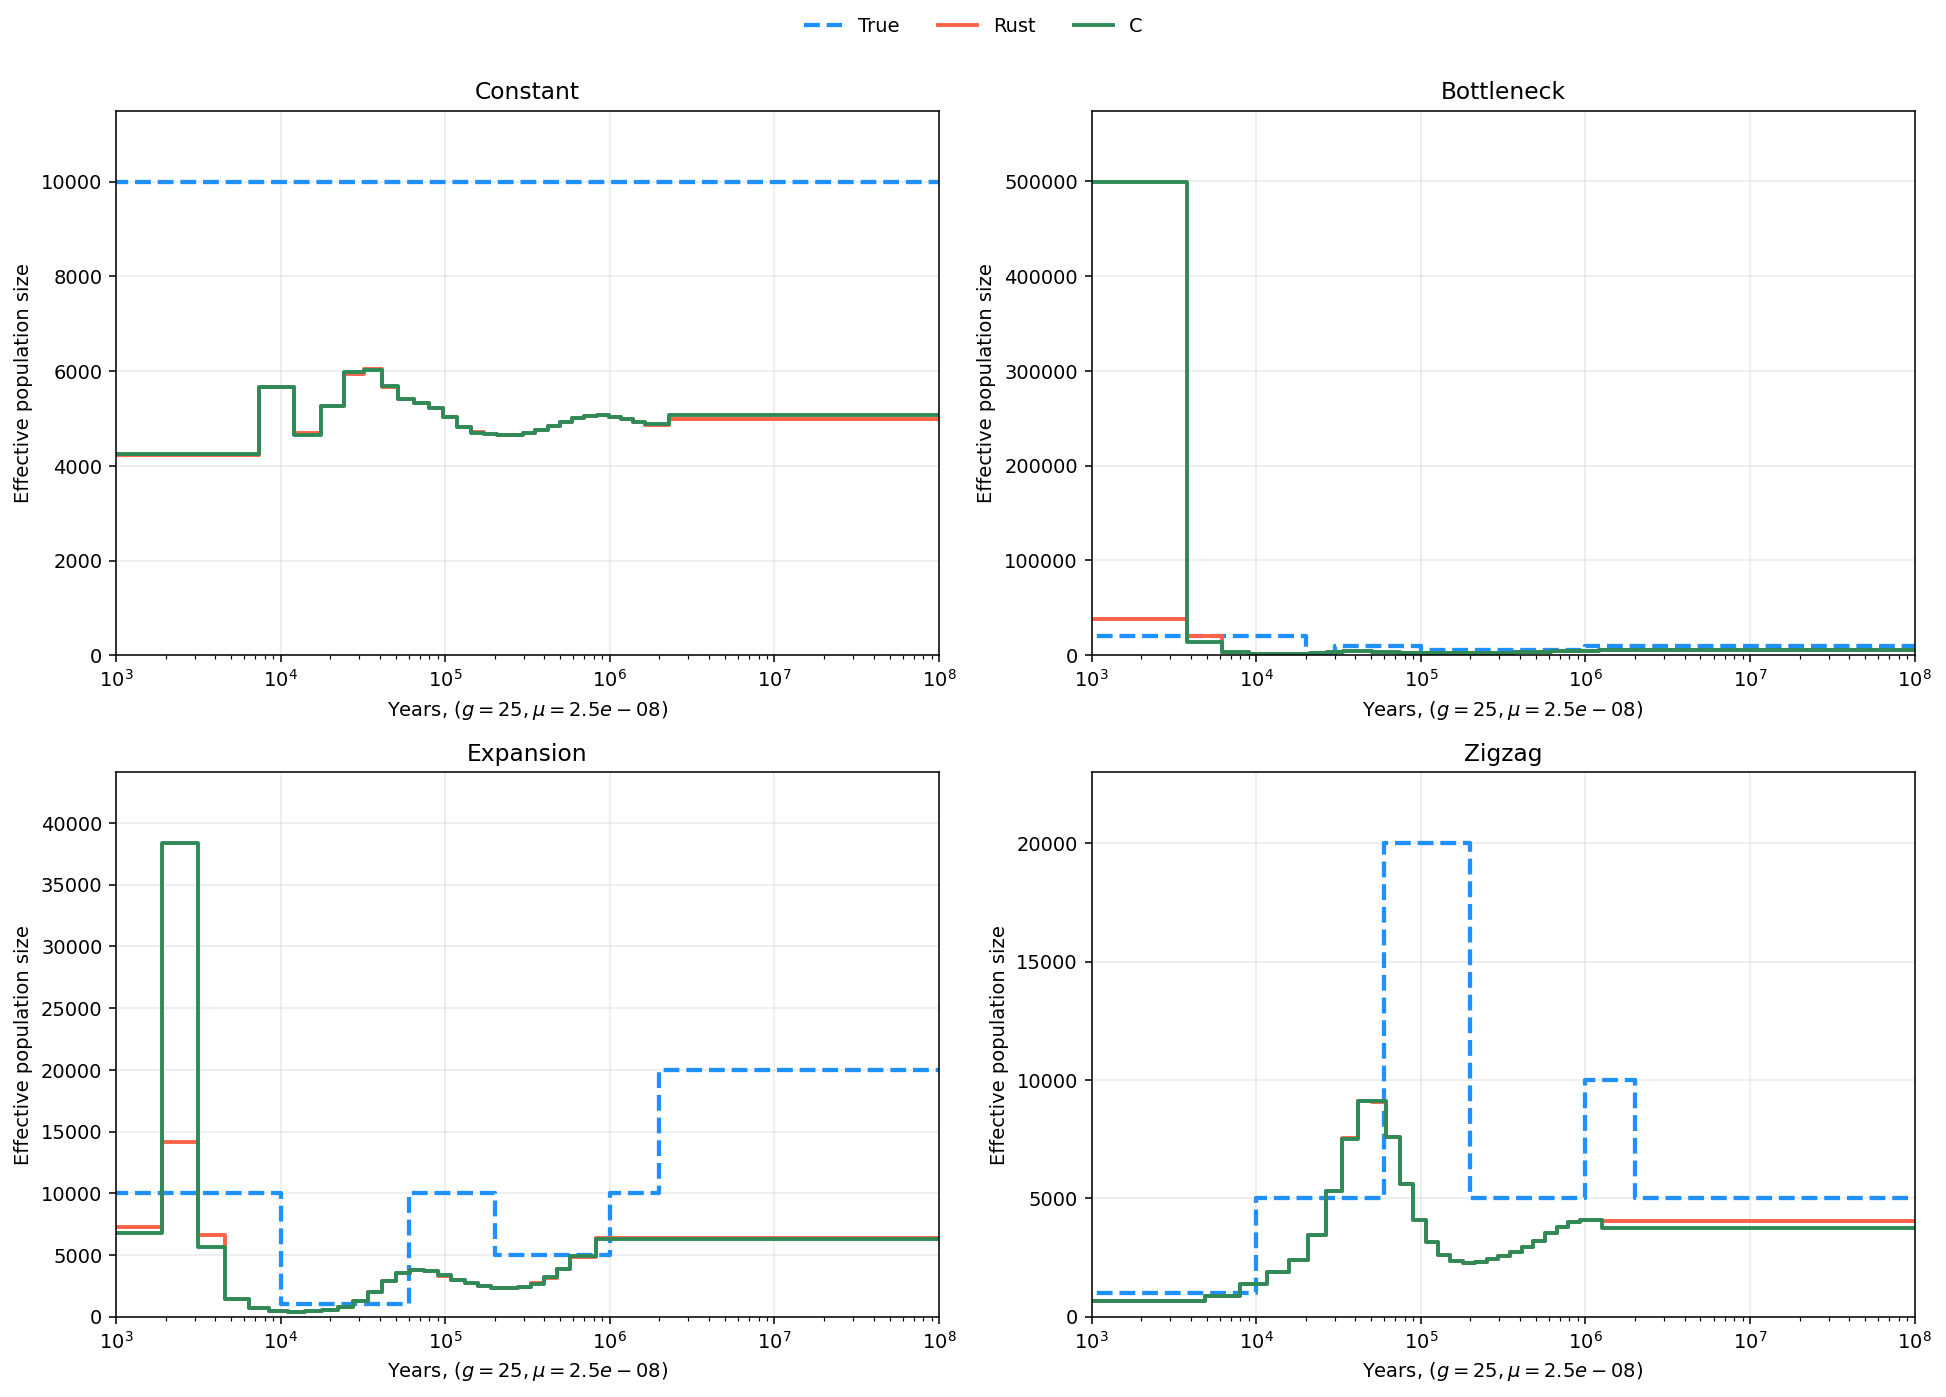

RMSE(log10 Ne) vs true (lower is better)


,model,tool,rmse_log10_ne
2,bottleneck,rust,0.445280
3,bottleneck,c,0.649065
1,constant,c,0.308742
0,constant,rust,0.311965
4,expansion,rust,0.467747
5,expansion,c,0.485561
6,zigzag,rust,0.313358
7,zigzag,c,0.319184


In [14]:
# Experiment 1: accuracy (single run) + curve plots
run_log_rows = []

for key in MODEL_ORDER:
    inp = model_input_path(key)
    rust_out = rust_json_path(key)
    r = run_rust(inp, rust_out, n_iter=N_ITER, batch_size=BATCH_SIZE_DEFAULT, threads=RUST_BASE_THREADS)
    run_log_rows.append({
        'model': key,
        'tool': 'rust',
        'wall_sec': r['wall_sec'],
        'peak_rss_mb': r['peak_rss_mb'],
        'output': str(rust_out),
    })

    if HAS_C:
        c_out = c_psmc_path(key)
        c = run_c(inp, c_out, n_iter=N_ITER)
        run_log_rows.append({
            'model': key,
            'tool': 'c',
            'wall_sec': c['wall_sec'],
            'peak_rss_mb': c['peak_rss_mb'],
            'output': str(c_out),
        })

run_log_df = pd.DataFrame(run_log_rows)
display(run_log_df)

metric_rows = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=140)
axes = axes.ravel()

for idx, key in enumerate(MODEL_ORDER):
    ax = axes[idx]
    true_curve = true_curve_for_model(key)
    rust_curve = load_json_curve(rust_json_path(key))
    c_curve = load_c_curve(c_psmc_path(key)) if HAS_C else None

    tx, ty = true_curve
    ax.step(tx, ty, where='post', lw=2.2, ls='--', color='dodgerblue', label='True')

    ymax = float(np.max(ty))
    if rust_curve is not None:
        x, y = rust_curve
        ax.step(x, y, where='post', lw=2.0, color='tomato', label='Rust')
        ymax = max(ymax, float(np.max(y)))
        metric_rows.append((key, 'rust', rmse_log10(true_curve, rust_curve)))

    if c_curve is not None:
        x, y = c_curve
        ax.step(x, y, where='post', lw=2.0, color='seagreen', label='C')
        ymax = max(ymax, float(np.max(y)))
        metric_rows.append((key, 'c', rmse_log10(true_curve, c_curve)))

    ax.set_title(MODELS[key]['title'])
    ax.set_xscale('log')
    ax.set_xlim(1e3, 1e8)
    ax.set_ylim(0, ymax * 1.15)
    ax.set_xlabel(fr'Years, $(g={GEN_YEARS}, \mu={MU:.1e})$')
    ax.set_ylabel('Effective population size')
    ax.grid(alpha=0.25)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, frameon=False)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

accuracy_df = pd.DataFrame(metric_rows, columns=['model', 'tool', 'rmse_log10_ne']).sort_values(['model', 'rmse_log10_ne'])
print('RMSE(log10 Ne) vs true (lower is better)')
display(accuracy_df)


In [ ]:
# Experiment 2: performance benchmark (runtime + peak RSS)
perf_rows = []
for rep in range(PERF_REPEATS):
    for key in MODEL_ORDER:
        inp = model_input_path(key)

        rust_out = PERF_DIR / f'{key}.rust.rep{rep+1}.json'
        r = run_rust(inp, rust_out, n_iter=N_ITER, batch_size=BATCH_SIZE_DEFAULT, threads=RUST_BASE_THREADS)
        perf_rows.append({
            'model': key,
            'tool': 'rust',
            'rep': rep + 1,
            'wall_sec': r['wall_sec'],
            'peak_rss_mb': r['peak_rss_mb'],
        })

        if HAS_C:
            c_out = PERF_DIR / f'{key}.c.rep{rep+1}.psmc'
            c = run_c(inp, c_out, n_iter=N_ITER)
            perf_rows.append({
                'model': key,
                'tool': 'c',
                'rep': rep + 1,
                'wall_sec': c['wall_sec'],
                'peak_rss_mb': c['peak_rss_mb'],
            })

perf_df = pd.DataFrame(perf_rows)
perf_summary = (
    perf_df
    .groupby(['model', 'tool'], as_index=False)
    .agg(
        wall_sec_mean=('wall_sec', 'mean'),
        wall_sec_std=('wall_sec', 'std'),
        peak_rss_mb_mean=('peak_rss_mb', 'mean'),
        peak_rss_mb_std=('peak_rss_mb', 'std'),
    )
    .sort_values(['model', 'tool'])
)
print('Performance summary:')
display(perf_summary)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8), dpi=140)

plot_df = perf_summary.copy()
for i, metric in enumerate(['wall_sec_mean', 'peak_rss_mb_mean']):
    ax = axes[i]
    models = MODEL_ORDER
    x = np.arange(len(models))
    width = 0.35

    rust_vals = [plot_df[(plot_df.model == m) & (plot_df.tool == 'rust')][metric].values[0] if len(plot_df[(plot_df.model == m) & (plot_df.tool == 'rust')]) else np.nan for m in models]
    c_vals = [plot_df[(plot_df.model == m) & (plot_df.tool == 'c')][metric].values[0] if len(plot_df[(plot_df.model == m) & (plot_df.tool == 'c')]) else np.nan for m in models]

    ax.bar(x - width/2, rust_vals, width=width, label='Rust', color='tomato', alpha=0.85)
    if HAS_C:
        ax.bar(x + width/2, c_vals, width=width, label='C', color='seagreen', alpha=0.85)

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15)
    ax.set_title('Runtime (s)' if metric.startswith('wall') else 'Peak RSS (MB)')
    ax.grid(axis='y', alpha=0.2)

axes[0].legend(frameon=False)
fig.tight_layout()
plt.show()


In [ ]:
# Experiment 2b: Rust multi-thread scaling
thread_rows = []
for rep in range(PERF_THREADS_REPEATS):
    for key in MODEL_ORDER:
        inp = model_input_path(key)
        for n_threads in THREADS_SWEEP:
            out_json = PERF_DIR / f'{key}.rust.t{n_threads}.rep{rep+1}.json'
            r = run_rust(
                inp,
                out_json,
                n_iter=N_ITER,
                batch_size=BATCH_SIZE_DEFAULT,
                threads=n_threads,
            )
            thread_rows.append({
                'model': key,
                'threads': n_threads,
                'rep': rep + 1,
                'wall_sec': r['wall_sec'],
                'peak_rss_mb': r['peak_rss_mb'],
            })

thread_df = pd.DataFrame(thread_rows)
thread_summary = (
    thread_df
    .groupby(['model', 'threads'], as_index=False)
    .agg(
        wall_sec_mean=('wall_sec', 'mean'),
        wall_sec_std=('wall_sec', 'std'),
        peak_rss_mb_mean=('peak_rss_mb', 'mean'),
        peak_rss_mb_std=('peak_rss_mb', 'std'),
    )
    .sort_values(['model', 'threads'])
)

base = (
    thread_summary[thread_summary['threads'] == 1][['model', 'wall_sec_mean']]
    .rename(columns={'wall_sec_mean': 'wall_sec_1thread'})
)
thread_summary = thread_summary.merge(base, on='model', how='left')
thread_summary['speedup_vs_1thread'] = thread_summary['wall_sec_1thread'] / thread_summary['wall_sec_mean']

print('Rust multi-thread summary:')
display(thread_summary)

speedup_geomean = (
    thread_summary
    .groupby('threads', as_index=False)
    .agg(geomean_speedup=('speedup_vs_1thread', lambda s: float(np.exp(np.log(s).mean()))))
    .sort_values('threads')
)
print('Geometric mean speedup across models:')
display(speedup_geomean)

fig, axes = plt.subplots(1, 2, figsize=(13, 4.8), dpi=140)

for key in MODEL_ORDER:
    sub = thread_summary[thread_summary['model'] == key]
    axes[0].plot(sub['threads'], sub['wall_sec_mean'], marker='o', label=key)
axes[0].set_xscale('log', base=2)
axes[0].set_xticks(THREADS_SWEEP)
axes[0].get_xaxis().set_major_formatter(plt.ScalarFormatter())
axes[0].set_xlabel('Threads')
axes[0].set_ylabel('Wall time (s)')
axes[0].set_title('Rust Runtime vs Threads')
axes[0].grid(alpha=0.25)
axes[0].legend(frameon=False, ncol=2)

for key in MODEL_ORDER:
    sub = thread_summary[thread_summary['model'] == key]
    axes[1].plot(sub['threads'], sub['speedup_vs_1thread'], marker='o', label=key)
axes[1].plot(speedup_geomean['threads'], speedup_geomean['geomean_speedup'], color='black', lw=2.5, linestyle='--', label='geomean')
axes[1].axhline(1.0, color='gray', lw=1, alpha=0.6)
axes[1].set_xscale('log', base=2)
axes[1].set_xticks(THREADS_SWEEP)
axes[1].get_xaxis().set_major_formatter(plt.ScalarFormatter())
axes[1].set_xlabel('Threads')
axes[1].set_ylabel('Speedup vs 1 thread')
axes[1].set_title('Rust Speedup Curve')
axes[1].grid(alpha=0.25)
axes[1].legend(frameon=False, ncol=2)

fig.tight_layout()
plt.show()


In [ ]:
# Experiment 3: batch-size robustness (Rust only)
batch_sizes = [None, 100_000, 300_000, 1_000_000]
robust_models = ['constant', 'zigzag']
robust_rows = []

for key in robust_models:
    true_curve = true_curve_for_model(key)
    for bs in batch_sizes:
        suffix = '.full' if bs is None else f'.bs{bs}'
        out_json = OUT_DIR / f'{key}.rust{suffix}.json'
        rec = run_rust(model_input_path(key), out_json, n_iter=N_ITER, batch_size=bs, threads=RUST_BASE_THREADS)
        curve = load_json_curve(out_json)
        err = rmse_log10(true_curve, curve)
        robust_rows.append({
            'model': key,
            'batch_size': 'None(full)' if bs is None else str(bs),
            'rmse_log10_ne': err,
            'wall_sec': rec['wall_sec'],
            'peak_rss_mb': rec['peak_rss_mb'],
        })

robust_df = pd.DataFrame(robust_rows)
print('Batch-size robustness:')
display(robust_df.sort_values(['model', 'batch_size']))

fig, axes = plt.subplots(1, 2, figsize=(12, 4.2), dpi=140)
for i, metric in enumerate(['rmse_log10_ne', 'wall_sec']):
    ax = axes[i]
    for key, sub in robust_df.groupby('model'):
        ax.plot(sub['batch_size'], sub[metric], marker='o', label=key)
    ax.set_title(metric)
    ax.set_xlabel('batch_size')
    ax.grid(alpha=0.25)
axes[0].legend(frameon=False)
fig.tight_layout()
plt.show()


In [ ]:
# Experiment 4: bootstrap CI behavior and coverage (Rust)

def bootstrap_coverage(model_key: str, bootstrap_reps: int = BOOTSTRAP_REPS, bootstrap_iters: int = BOOTSTRAP_ITERS):
    inp = model_input_path(model_key)
    out_json = OUT_DIR / f'{model_key}.rust.bootstrap_main.json'
    boot_dir = OUT_DIR / f'{model_key}.rust.bootstrap'

    extra = [
        '--bootstrap', str(bootstrap_reps),
        '--bootstrap-iters', str(bootstrap_iters),
        '--bootstrap-block-size', '50000',
        '--bootstrap-seed', '42',
        '--bootstrap-dir', str(boot_dir),
    ]
    rec = run_rust(inp, out_json, n_iter=N_ITER, batch_size=BATCH_SIZE_DEFAULT, threads=RUST_BASE_THREADS, extra=extra)

    summ = pd.read_csv(boot_dir / 'summary.tsv', sep='	')
    tx, ty = true_curve_for_model(model_key)
    true_vals = np.array([step_value(tx, ty, x) for x in summ['x_years'].values], dtype=float)
    covered = (true_vals >= summ['ne_q025'].values) & (true_vals <= summ['ne_q975'].values)
    coverage = float(np.mean(covered))

    out = summ.copy()
    out['ne_true'] = true_vals
    out['covered'] = covered.astype(int)
    return out, coverage, rec

boot_model = 'zigzag'
boot_df, coverage, boot_rec = bootstrap_coverage(boot_model)
print(f'Bootstrap coverage for {boot_model}: {coverage:.3f}')
print(f'wall_sec={boot_rec["wall_sec"]:.2f}, peak_rss_mb={boot_rec["peak_rss_mb"]}')

fig, ax = plt.subplots(figsize=(8.8, 4.6), dpi=140)
ax.fill_between(boot_df['x_years'], boot_df['ne_q025'], boot_df['ne_q975'], step='post', alpha=0.25, color='lightskyblue', label='Bootstrap 95% CI')
ax.step(boot_df['x_years'], boot_df['ne_q500'], where='post', color='royalblue', lw=1.7, label='Bootstrap median')
ax.step(boot_df['x_years'], boot_df['ne_main'], where='post', color='tomato', lw=1.7, label='Rust main')
ax.step(boot_df['x_years'], boot_df['ne_true'], where='post', color='seagreen', lw=1.8, ls='--', label='True')
ax.set_xscale('log')
ax.set_xlim(1e3, 1e8)
ax.set_xlabel('Years')
ax.set_ylabel('Effective population size (Ne)')
ax.set_title(f'Bootstrap CI: {boot_model} (coverage={coverage:.3f})')
ax.grid(alpha=0.25)
ax.legend(frameon=False)
plt.show()


In [ ]:
# Save key result tables for manuscript reuse
if 'accuracy_df' in globals() and isinstance(accuracy_df, pd.DataFrame):
    accuracy_df.to_csv(EXP_DIR / 'accuracy_summary.csv', index=False)
if 'perf_summary' in globals() and isinstance(perf_summary, pd.DataFrame):
    perf_summary.to_csv(EXP_DIR / 'performance_summary.csv', index=False)
if 'robust_df' in globals() and isinstance(robust_df, pd.DataFrame):
    robust_df.to_csv(EXP_DIR / 'batchsize_robustness.csv', index=False)
if 'boot_df' in globals() and isinstance(boot_df, pd.DataFrame):
    boot_df.to_csv(EXP_DIR / 'bootstrap_curve_table.csv', index=False)

print('Saved tables under:', EXP_DIR)
for p in sorted(EXP_DIR.glob('*.csv')):
    print(' -', p.name)


## Notes

- Use `PSMC_FAST=1` in environment for quick smoke runs:
  - `SIM_LENGTH=50Mb`
  - `PERF_REPEATS=1`
  - `BOOTSTRAP_REPS=10`
- For final paper-quality results, keep `PSMC_FAST=0` (default) and run on a fixed machine.
- This notebook intentionally stores all generated artifacts under:
  - `experiments/core/inputs`
  - `experiments/core/outputs`
  - `experiments/core/perf`
